<a href="https://colab.research.google.com/github/vranade-cyber/Probabilistic-Determination-of-Osteoporosis/blob/main/DL4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import sys
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.utils.rnn as rnn_utils
import torch.optim as optim
import torch.nn.utils as utils
import seaborn as sns
import matplotlib.pyplot as plt
import time
import random
from torch.utils import data

from torch.optim.lr_scheduler import ReduceLROnPlateau

from torch.utils.data import DataLoader, Dataset 
from torch.distributions.bernoulli import Bernoulli
from torch.distributions.gumbel import Gumbel
from torch.distributions.uniform import Uniform
from pandas import DataFrame as df
cuda = torch.cuda.is_available()
print(cuda, sys.version)
device = torch.device("cuda" if cuda else "cpu")
np.random.seed(2412)
torch.manual_seed(2412)



LETTER_LIST = ['<sos>', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 
               'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '-', "'", '.', '_', '+', ' ', '<eos>']

True 3.7.12 (default, Sep 10 2021, 00:21:48) 
[GCC 7.5.0]


In [ ]:
from typing import List, Tuple,Dict

def create_dictionaries(letter_list: List[str]) -> Tuple[Dict[str, int], Dict[int, str]]:
    '''
    Create dictionaries for letter2index and index2letter transformations
    '''
    #pass
    letter2index={}
    index2letter={}
    #print(type(letter2index))
    for i in range(len(letter_list)):
      letter2index.update({letter_list[i]:i})
      index2letter.update({i:letter_list[i]})
    #print(letter2index)
    #print(index2letter)
    #transcripts=[]

    return letter2index,index2letter
    
      
    
def transform_letter_to_index(raw_transcripts: List[str]) -> List[int]:
    '''
    Transforms text input to numerical input by converting each letter 
    to its corresponding index from letter_list

    Args:
        raw_transcripts: Raw text transcripts with the shape of (N, )
    
    Return:
        transcripts: Converted index-format transcripts. This would be a list with a length of N
    '''
    
    letter_list=[]
    n=len(raw_transcripts)
    
    for i in range(n):

      sentence=raw_transcripts[i]
      sentence_list=[0]
      for j in range(len(sentence)):
        word=sentence[j]
        for c in word:
          sentence_list.append(letter2index[c])

        if j>0:
          sentence_list.append(letter2index[' '])
        
      sentence_list.append(letter2index['<eos>'])
      letter_list.append(sentence_list)




    return letter_list
letter2index, index2letter = create_dictionaries(LETTER_LIST)

In [ ]:
print(transform_letter_to_index(list(('abba','aaabbbaaac','abcdefg'))))

[[0, 1, 2, 32, 2, 32, 1, 32, 33], [0, 1, 1, 32, 1, 32, 2, 32, 2, 32, 2, 32, 1, 32, 1, 32, 1, 32, 3, 32, 33], [0, 1, 2, 32, 3, 32, 4, 32, 5, 32, 6, 32, 7, 32, 33]]


In [ ]:
dev= np.load('/content/drive/MyDrive/hw4p2_toy_dataset/dev.npz',allow_pickle=True,encoding='bytes')
valid_data=dev['data']
dev_transcripts=np.load('/content/drive/MyDrive/hw4p2_toy_dataset/dev_transcripts.npz',allow_pickle=True,encoding='bytes')
raw_valid_transcripts=list(dev_transcripts['data'])
train=np.load('/content/drive/MyDrive/hw4p2_toy_dataset/train.npz',allow_pickle=True,encoding='bytes')
train_data=train['data']
raw_train_transcripts=np.load('/content/drive/MyDrive/hw4p2_toy_dataset/train_transcripts.npz',allow_pickle=True,encoding='bytes')
raw_train_transcripts=list(raw_train_transcripts['data'])

In [ ]:
q=transform_letter_to_index(dev_transcripts.f.data[0])
print(q)

[[0, 19, 33], [0, 24, 33], [0, 13, 33], [0, 1, 33], [0, 4, 33], [0, 24, 33], [0, 3, 33], [0, 13, 33], [0, 15, 33], [0, 14, 33], [0, 17, 33], [0, 13, 33], [0, 5, 33], [0, 8, 33], [0, 20, 33], [0, 6, 33], [0, 24, 33], [0, 2, 33], [0, 21, 33], [0, 3, 33], [0, 3, 33], [0, 17, 33], [0, 24, 33], [0, 16, 33], [0, 2, 33], [0, 4, 33], [0, 2, 33], [0, 16, 33], [0, 8, 33]]


In [ ]:
dev.f.data[0][:,0]

array([25., 30., 19.,  7., 10., 30.,  9., 19., 21., 20., 23., 19., 11.,
       14., 26., 12., 30.,  8., 27.,  9.,  9., 23., 30., 22.,  8., 10.,
        8., 22., 14.], dtype=float32)

In [ ]:
train_transcript = transform_letter_to_index(raw_train_transcripts)
valid_transcript = transform_letter_to_index(raw_valid_transcripts)

In [ ]:
from torch.nn.utils.rnn import pad_sequence

class MyDataset(data.Dataset):
    def __init__(self, X, Y):
        self.X = X
        if Y is not None:
          self.Y = Y

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, index):
        # For testing set, return only x
        if self.Y is None:
            return torch.as_tensor(self.X[index])
        # For training and validation set, return x and y
        else:
            return torch.as_tensor(self.X[index]), torch.as_tensor(self.Y[index])

def collate_train_val(data):
    """
    Return:
        pad_x: the padded x (training/validation speech data) 
        pad_y: the padded y (text labels - transcripts)
        x_len: the length of x
        y_len: the length of y
    """
    # Consider batch_first = True
    #pass

    (xx,yy)=zip(*data)

    x_len=torch.LongTensor([len(x) for x in xx ])
    y_len=torch.LongTensor([len(y) for y in yy ])

    pad_x=pad_sequence(xx,batch_first=True)
    pad_y=pad_sequence(yy,batch_first=True)

    return pad_x,pad_y,x_len,y_len

def collate_test(data):
    """
    Return:
        pad_x: the padded x (testing speech data) 
        x_len: the length of x
    """
    x_len = torch.Tensor([len(xx) for xx in data])
    x  = [xx for xx in data]
    pad_x=pad_sequence(x,batch_first=True)
    
    return pad_x,x_len

In [ ]:
train_dataset = MyDataset(train_data,train_transcript)
valid_dataset = MyDataset(valid_data,valid_transcript)
#test_dataset = # fill this out
train_args =  dict(shuffle=True,batch_size=64,num_workers=4,collate_fn=collate_train_val)
val_args   =  dict(shuffle=False,batch_size=64,num_workers=4,collate_fn=collate_train_val)
# Create data loaders
train_loader = data.DataLoader(train_dataset,**train_args)
val_loader = data.DataLoader(valid_dataset,**val_args)

In [ ]:
class Encoder(nn.Module):
  def __init__(self, input_dim, hidden_dim, value_size=128,key_size=128):
    super(Encoder, self).__init__()
    self.lstm = nn.LSTM(input_size=input_dim,hidden_size=hidden_dim,num_layers=1,bidirectional=True, batch_first = True)
    
    self.key_network = nn.Linear(hidden_dim*2, value_size)
    self.value_network = nn.Linear(hidden_dim*2, key_size)
  
  def forward(self,x, lens):
    rnn_inp = utils.rnn.pack_padded_sequence(x, lengths=lens, batch_first=True, enforce_sorted=False)
    outputs, _ = self.lstm(rnn_inp)
    
    linear_input, lens = utils.rnn.pad_packed_sequence(outputs, batch_first = True)
    keys = self.key_network(linear_input)
    value = self.value_network(linear_input)

    return keys, value, lens

In [ ]:
class Attention(nn.Module):
  def __init__(self):
    super(Attention, self).__init__()
  def forward(self, query, key, value, lens):
    '''
    :param query :(N,context_size) Query is the output of LSTMCell from Decoder
    :param key: (N,key_size) Key Projection from Encoder per time step
    :param value: (N,value_size) Value Projection from Encoder per time step
    :return output: Attended Context
    :return attention_mask: Attention mask that can be plotted  
    '''

    energy = torch.bmm(key, query.unsqueeze(2)).squeeze(2)
    mask = torch.arange(key.size(1)).unsqueeze(0) >= lens.unsqueeze(1)
    mask = mask.cuda()
    energy.masked_fill_(mask, -1e9)
    attention = nn.functional.softmax(energy, dim = 1)
    context = torch.bmm(attention.unsqueeze(1), value).squeeze(1)

    return context, attention

In [ ]:
class Decoder(nn.Module):
  def __init__(self, vocab_size, hidden_dim, value_size=128, key_size=128,  isAttended=False):
    super(Decoder, self).__init__()
    self.embedding = nn.Embedding(vocab_size, hidden_dim)
    
    self.lstm1 = nn.LSTMCell(input_size=hidden_dim+value_size, hidden_size=hidden_dim)
    self.lstm2 = nn.LSTMCell(input_size=hidden_dim, hidden_size=key_size)
    self.isAttended = isAttended
    if(isAttended):
      self.attention = Attention()
    self.character_prob = nn.Linear(key_size+value_size,vocab_size)
    self.key_size = key_size

  def forward(self, key, values, lens, text=None, train=True, val=False):
    
    # implement teacher forcing
    p = 0.6
    m = Bernoulli(torch.tensor([p]))
    attention_plot=[]
    # because all code in encoder written with batch_first = True
    batch_size = key.shape[0]
    if(train):
      max_len =  text.shape[1]
      embeddings = self.embedding(text)
    else:
      max_len = 250
    # start of sequence index
    sos = torch.LongTensor([0]).cuda()

    predictions = []
    hidden_states = [None, None]
    prediction = torch.zeros(batch_size,1).to(device)
    # values = torch.zeros(batch_size, max_len, 128).cuda()

    # the initial query to attention will be all zeros
    output = torch.zeros(batch_size, self.key_size).cuda()
    for i in range(max_len):

      
      if(train):

        # this line implements teacher forcing
        if (m.sample() == 1 and i!=0 and val == False):
            char_embed = self.embedding(prediction.argmax(dim=-1))
        else:
            char_embed = embeddings[:,i,:]
      else:
        if i == 0:
            char_embed = self.embedding(sos.expand(batch_size,1).cuda()).squeeze(1)
        else:
            char_embed = self.embedding(F.log_softmax(prediction, dim=-1))
      context, attention = self.attention(output, key, values, lens)
      
      inp = torch.cat([char_embed, context], dim=1)
      hidden_states[0] = self.lstm1(inp,hidden_states[0])
      inp_2 = hidden_states[0][0]
      hidden_states[1] = self.lstm2(inp_2,hidden_states[1])

      output = hidden_states[1][0]
      #print('output_shape',output.shape)

      prediction = self.character_prob(torch.cat([output, context], dim=1))      
      predictions.append(prediction.unsqueeze(1))
      #print('Prediction size',prediction[0].shape)
      #print('Attention.shape',attention.shape)
      attention_plot.append(attention[0].detach().cpu())
      #plot_attention(attention_plot)
      #predictions=torch.cat(predictions, dim=1)
      #print('Pred_shape',predictions.shape)
      pred=torch.cat(predictions,dim=1)
    return pred , attention

In [ ]:
class Seq2Seq(nn.Module):
  def __init__(self,input_dim,vocab_size,hidden_dim,value_size=128, key_size=128,isAttended=True):
    super(Seq2Seq,self).__init__()

    self.encoder = Encoder(input_dim, 256)
    self.decoder = Decoder(vocab_size, 512, isAttended=True)
  def forward(self,speech_input, speech_len, text_input=None, train = True, val = False):
    key, value, lens = self.encoder(speech_input, speech_len)
    if(train):
      predictions, attention = self.decoder(key, value, lens, text_input, train, val)
    else:
      predictions, attention = self.decoder(key, value, lens, text=None, train=False)
    return predictions, attention

In [ ]:
model = Seq2Seq(input_dim=40,vocab_size=len(LETTER_LIST),hidden_dim=256)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss(reduction = 'none').to(device)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=1, verbose=True)

In [ ]:
def train(model,train_loader, num_epochs, criterion, optimizer):
  for epochs in range(num_epochs):
    loss_sum = 0
    since = time.time()
    best_val = float('inf')
    att=[]
    for batch_num, collate_output in enumerate(train_loader):
      all_attentions = []
      with torch.autograd.set_detect_anomaly(True):
        optimizer.zero_grad()
        speech_input, text_input, speech_len, text_len = collate_output
        speech_input = speech_input.to(device)
        text_input = text_input.to(device)
        predictions, attention = model(speech_input, speech_len ,text_input)
        all_attentions.append(attention.detach())
        #print(attention.size)
        #att.append(attention[:,0,:])
        predictions = predictions[:,:-1,:]
        text_input = text_input[:,1:]
        mask_text = torch.zeros(text_input.size()).cuda()
        for i in range(text_len.shape[0]):
          mask_text[i,:text_len[i]] = 1
        
        mask_text = mask_text.contiguous().view(-1)

        predictions = predictions.contiguous().view(-1, predictions.size(-1))
        text_input = text_input.contiguous().view(-1)
        print('Pred_shape',predictions.shape)
        print('Y shape',text_input.shape)
        loss = criterion(predictions, text_input)
        masked_loss = torch.sum(loss*mask_text)
        masked_loss.backward()

        torch.nn.utils.clip_grad_norm_(model.parameters(), 2)
        optimizer.step()

        current_loss = float(masked_loss.item()/torch.sum(mask_text).item())

        if  batch_num % 25 == 1:
          print('[TRAIN]  Epoch [%d/%d]   Loss: %.4f'
                      % (batch_num, epochs+1, current_loss))
        
    all_attentions = torch.stack(all_attentions, dim=0)
    val_loss = validate(model, val_loader, criterion)
    scheduler.step(val_loss)
    #plt.figure()
    #plt.plot(attention[0].cpu().detach().numpy())
    #plt.show()
    #plot_attention(att.cpu().detach().numpy())
    print((all_attentions[:,0,:].cpu().detach().numpy().T).shape)
    plot_attention(all_attentions[:,0,:].cpu().detach().numpy().T)

In [ ]:
def validate(model,val_loader, criterion):
    model.eval()
    for batch_num, collate_output in enumerate(val_loader):
      total_loss = 0
      count = 0
      attention_plot=[]
      with torch.autograd.set_detect_anomaly(True):
        
        speech_input, text_input, speech_len, text_len = collate_output
        speech_input = speech_input.to(device)
        text_input = text_input.to(device)

        predictions, attention = model(speech_input, speech_len ,text_input, val = True)
        attention_plot.append(attention)
        predictions = predictions[:,:-1,:]
        text_input = text_input[:,1:]
        mask_text = torch.zeros(text_input.size()).cuda()
        for i in range(text_len.shape[0]):
          mask_text[i,:text_len[i]] = 1
        
        mask_text = mask_text.contiguous().view(-1)

        predictions = predictions.contiguous().view(-1, predictions.size(-1))
        text_input = text_input.contiguous().view(-1)
        
        loss = criterion(predictions, text_input)
        masked_loss = torch.sum(loss*mask_text)
        current_loss = float(masked_loss.item()/torch.sum(mask_text).item())
        total_loss += current_loss
        count += 1
    
    model.train()
    total_loss = total_loss/count
    print('val_loss', total_loss)
    return total_loss
    plot_attention(attention[:,0,:])

In [ ]:
def plot_attention(attention):
    # utility function for debugging
    plt.clf()
    sns.heatmap(attention, cmap='GnBu')
    plt.show()

Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
[TRAIN]  Epoch [1/1]   Loss: 2.6050
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.S

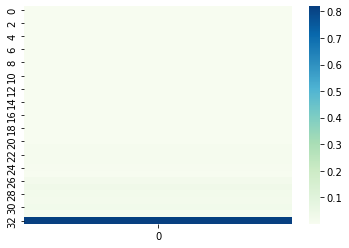

Pred_shape torch.Size([4224, 34])
Y shape torch.Size([4224])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
[TRAIN]  Epoch [1/2]   Loss: 1.6933
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.S

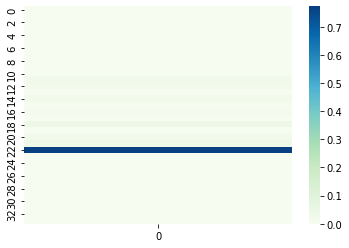

Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
[TRAIN]  Epoch [1/3]   Loss: 1.6947
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.S

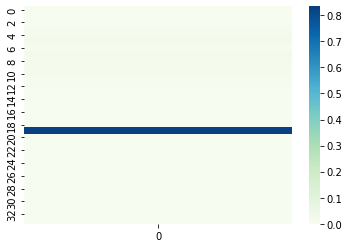

Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
[TRAIN]  Epoch [1/4]   Loss: 1.6869
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.S

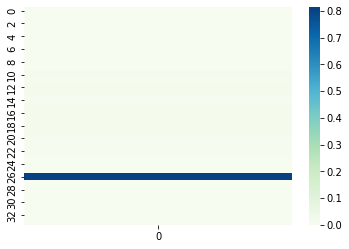

Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
[TRAIN]  Epoch [1/5]   Loss: 1.6836
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4224, 34])
Y shape torch.Size([4224])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.S

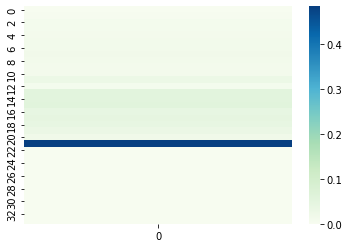

Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4224, 34])
Y shape torch.Size([4224])
[TRAIN]  Epoch [1/6]   Loss: 1.6314
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.S

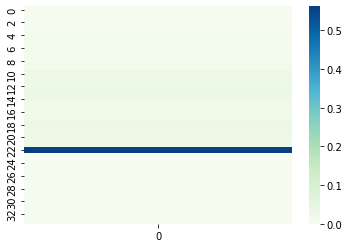

Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
[TRAIN]  Epoch [1/7]   Loss: 1.6391
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4224, 34])
Y shape torch.Size([4224])
Pred_shape torch.Size([4352, 34])
Y shape torch.S

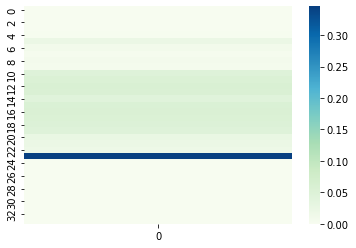

Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
[TRAIN]  Epoch [1/8]   Loss: 1.5994
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.Size([4352])
Pred_shape torch.Size([4352, 34])
Y shape torch.S

In [ ]:
model = Seq2Seq(input_dim=40,vocab_size=len(LETTER_LIST),hidden_dim=256)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.002)
criterion = nn.CrossEntropyLoss(reduction = 'none').to(device)

n_epochs = 10
mode = 'train'

train(model,train_loader, 10, criterion, optimizer)


In [ ]:
for batch, (data,xlen,label,ylen) in enumerate(val_loader):
  print(batch)
  print(data.shape)

In [ ]:
raw_train_transcripts[1]

In [ ]:
encoder = Encoder(40, 512)
for data in train_loader:
    x, y, lx, ly = data
    k, v, l = encoder(x, lx)
    print("Key:", k.shape)
    print("Value:", v.shape)
    print("Length:", l.shape)
    break
